In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
import gensim
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss,accuracy_score
import scikitplot.plotters as skplt
import xgboost 
from xgboost import XGBClassifier

In [2]:
!pip install scikit-plot

In [4]:
data=pd.read_csv("mtsamples.csv")
data.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [5]:
data.shape

(4999, 6)

In [6]:
data1=data.groupby('medical_specialty').filter(lambda x : len(x)>50)

In [7]:
data1.shape

(4680, 6)

In [8]:
data1.dropna(axis=0,inplace=True)
data1.shape

(3650, 6)

In [9]:
data1.isnull().sum()

Unnamed: 0           0
description          0
medical_specialty    0
sample_name          0
transcription        0
keywords             0
dtype: int64

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
#compile a regular expression pattern

special_character_remover = re.compile('[/(){}\[\]\|@,;]')
extra_symbol_remover = re.compile('[^a-z.]')
STOPWORDS = set(stopwords.words('english'))

In [12]:
# Function to clean the text

def clean_text(text):
    text = text.lower()
    text = special_character_remover.sub(' ',text)
    text = extra_symbol_remover.sub(' ',text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [13]:
data1['transcription'] = data1['transcription'].apply(clean_text)

In [14]:
# Lemmatization function 

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)      # sent_tokenize() method to split a document or paragraph into sentences.
    
    for sentence in sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))    
    return ' '.join(wordlist) 

In [15]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

In [17]:
# Lemmatization

data1['transcription'] = data1['transcription'].apply(lemmatize_text)

In [18]:
print('Sample transcription 1:'+data1.iloc[4]['transcription']+'\n')
print('Sample transcription 2:'+data1.iloc[14]['transcription']+'\n')

Sample transcription 1:study . mild aortic stenosis widely calcified minimally restricted . . mild left ventricular hypertrophy normal systolic function . . moderate biatrial enlargement . . normal right ventricle . . normal appearance tricuspid mitral valve . . normal left ventricle left ventricular systolic function . doppler . aortic regurgitation easily seen aortic stenosis . . mild tricuspid regurgitation mild increase right heart pressure mmhg maximum . summary . normal left ventricle . . moderate biatrial enlargement . . mild tricuspid regurgitation mild increase right heart pressure .

Sample transcription 2:sample address sample patient wife name sample name dear sample doctor mr. sample patient seen month dd yyyy describing vasectomy year ago failed vasectomy reversal done almost two year ago university michigan . remained azoospermic postoperatively . operative note suggests presence sperm sperm head right side time vasectomy reversal . state interested sperm harvesting cryo

In [19]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [20]:
encoder = LabelEncoder()
labels = data1['medical_specialty'] #.tolist()
#labels

encoded_labels = encoder.fit_transform(labels)
print(encoded_labels)

[0 0 0 ... 0 0 0]


In [21]:
med_speci=data1.transcription
med_speci

3       mode . left atrial enlargement left atrial dia...
4       . left ventricular cavity size wall thickness ...
7       echocardiogram multiple view heart great vesse...
9       description . normal cardiac chamber size . . ...
11      study . mild aortic stenosis widely calcified ...
                              ...                        
4967    exam left heart cath selective coronary angiog...
4968    indication acute coronary syndrome . consent f...
4971    angina chest pain due lack oxygen heart often ...
4972    indication chest pain . type test adenosine nu...
4975    history present illness mr. abc year old gentl...
Name: transcription, Length: 3650, dtype: object

In [23]:
a=[encoded_labels,med_speci]
#a.shape
a

[array([0, 0, 0, ..., 0, 0, 0]),
 3       mode . left atrial enlargement left atrial dia...
 4       . left ventricular cavity size wall thickness ...
 7       echocardiogram multiple view heart great vesse...
 9       description . normal cardiac chamber size . . ...
 11      study . mild aortic stenosis widely calcified ...
                               ...                        
 4967    exam left heart cath selective coronary angiog...
 4968    indication acute coronary syndrome . consent f...
 4971    angina chest pain due lack oxygen heart often ...
 4972    indication chest pain . type test adenosine nu...
 4975    history present illness mr. abc year old gentl...
 Name: transcription, Length: 3650, dtype: object]

In [24]:
# Create the dataframe of 'text' & class labels
col=['label','transcription']
df=pd.DataFrame(a).T
df.head()

,0,1
0,0,mode . left atrial enlargement left atrial dia...
1,0,. left ventricular cavity size wall thickness ...
2,0,echocardiogram multiple view heart great vesse...
3,0,description . normal cardiac chamber size . . ...
4,0,study . mild aortic stenosis widely calcified ...


In [25]:
df.shape

(3650, 2)

In [26]:
df[0]

0       0
1       0
2       0
3       0
4       0
       ..
3645    0
3646    0
3647    0
3648    0
3649    0
Name: 0, Length: 3650, dtype: object

In [27]:
df[0]  = df[0].astype('int')

In [28]:
df.iloc[:,0]

0       0
1       0
2       0
3       0
4       0
       ..
3645    0
3646    0
3647    0
3648    0
3649    0
Name: 0, Length: 3650, dtype: int32

In [29]:
# size : int, optional --  Dimensionality of the word vectors.
# window : int, optional --Maximum distance between the current and predicted word within a sentence.
#  min_count : int, optional  -- Ignores all words with total frequency lower than this.

In [36]:
# Create CBOW model
model1 = gensim.models.Word2Vec(df.iloc[:,1], min_count = 2,
                              vector_size = 100, window = 5)

In [37]:
#help(gensim.models.Word2Vec)

In [38]:
print(model1)
vocabulary=model1.wv.vocab
print(vocabulary)

Word2Vec<vocab=28, vector_size=100, alpha=0.025>


AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

Define helper function get_word2vec and helper class MySentences for training word2vec on the corpus of texts. (or loading if already trained and saved to disk)

In [29]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

Start training the word2vec model. Since word2vec training is unsupervised, you can use both training and test datasets.

In [32]:
w2vec = get_word2vec(
    MySentences(
        df.iloc[:,1].values, 
        #df_test['Text'].values  Commented for Kaggle limits
    ),
    'w2vmodel'
)

w2vmodel not found. training model
Model done training. Saving to disk


Now that we have our word2vec model, how do we use it to transform each documents into a feature vector? In order to convert a document of multiple words into a single vector using our trained word2vec, we take the word2vec of all words in the document, then take its mean.
We'll define a transformer (with sklearn interface) to convert a document into its corresponding vector

In [33]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [34]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [37]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(df.iloc[:,1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


In [65]:
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.7249217935691055
Accuracy: 0.3920547945205479


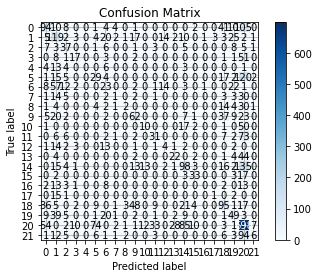

In [70]:
evaluate_features(mean_embedded, df.iloc[:,0].values.ravel())

In [76]:
mean_embedded_test = mean_embedding_vectorizer.transform(df[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


 Build XGBoost Model

In [78]:
xgb_w2vec = XGBClassifier(max_depth=4,
                          objective='multi:softprob',
                          learning_rate=0.03333)
xgb_w2vec.fit(mean_embedded, df[0])
probas = xgb_w2vec.predict_proba(mean_embedded_test)
submission_df = pd.DataFrame(probas, columns=['class'+str(c+1) for c in range(22)])
submission_df['ID'] = df[0]
submission_df.to_csv('submission.csv', index=False)

In [79]:
submission_df

,class1,class2,class3,class4,class5,class6,class7,class8,class9,class10,...,class14,class15,class16,class17,class18,class19,class20,class21,class22,ID
0,0.461638,0.019777,0.007162,0.009898,0.010014,0.011105,0.011538,0.007815,0.012786,0.018377,...,0.010121,0.008682,0.007077,0.007323,0.006920,0.329575,0.007761,0.016591,0.008652,0
1,0.428970,0.012166,0.006498,0.009153,0.006671,0.011282,0.007058,0.007064,0.009252,0.021065,...,0.009032,0.008237,0.006421,0.006644,0.006279,0.394911,0.007042,0.010614,0.007114,0
2,0.425246,0.012016,0.006396,0.009780,0.007790,0.007565,0.009712,0.006738,0.013970,0.013688,...,0.009368,0.007851,0.006484,0.006858,0.006374,0.378073,0.011728,0.027718,0.009939,0
3,0.417826,0.021945,0.010872,0.014252,0.015457,0.013874,0.016829,0.011819,0.017805,0.022325,...,0.013458,0.021839,0.010685,0.011302,0.010505,0.279345,0.013066,0.016484,0.016773,0
4,0.366389,0.022241,0.009650,0.008113,0.016140,0.007261,0.028761,0.007687,0.009889,0.019361,...,0.010041,0.019200,0.006950,0.007230,0.006833,0.402070,0.008131,0.008662,0.008543,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,0.480772,0.011136,0.007340,0.008353,0.007891,0.009726,0.007360,0.009885,0.017833,0.026508,...,0.009500,0.013106,0.007440,0.007741,0.007315,0.261262,0.007463,0.063948,0.008700,0
3646,0.422149,0.006644,0.006445,0.006954,0.006929,0.011608,0.006462,0.006854,0.013552,0.012324,...,0.009141,0.008902,0.006856,0.007103,0.006423,0.041894,0.006503,0.381723,0.007639,0
3647,0.338385,0.189108,0.019767,0.011733,0.011781,0.009667,0.013574,0.017016,0.028923,0.030565,...,0.013263,0.085830,0.009252,0.022463,0.009127,0.031957,0.099183,0.010435,0.013690,0
3648,0.430261,0.016225,0.009480,0.008706,0.011281,0.011756,0.007633,0.007097,0.011944,0.017284,...,0.008775,0.007821,0.008921,0.010450,0.006712,0.371082,0.006940,0.009171,0.007565,0


In [84]:
#probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(), 
#                              n_jobs=-1, method='predict_proba', verbose=2)  mean_embedded, df.iloc[:,0].values.ravel()
pred_indices = np.argmax(probas, axis=1) #probas
classes = np.unique(df[0])
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(df[0], probas)))
print('Accuracy: {}'.format(accuracy_score(df[0], preds)))

Log loss: 1.2392899992572117
Accuracy: 0.49068493150684933


In [ ]:
help(gensim.models.Word2Vec())

Help on Word2Vec in module gensim.models.word2vec object:

class Word2Vec(gensim.models.base_any2vec.BaseWordEmbeddingsModel)
 |  Word2Vec(sentences=None, corpus_file=None, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, iter=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=(), max_final_vocab=None)
 |  
 |  Train, use and evaluate neural networks described in https://code.google.com/p/word2vec/.
 |  
 |  Once you're finished training a model (=no more updates, only querying)
 |  store and use only the :class:`~gensim.models.keyedvectors.KeyedVectors` instance in `self.wv` to reduce memory.
 |  
 |  The model can be stored/loaded via its :meth:`~gensim.models.word2vec.Word2Vec.save` and
 |  :meth:`~gensim.models.word2vec.Word2Vec.load` methods.
 |  
 |  The trained word vectors can 